In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from numpy import cos, sin, pi, sqrt, real, imag, matmul
from scipy.fft import fft, fftfreq

In [2]:
import seaborn as sns
sns.set_context("paper")
sns.set(font_scale=1, style='white')
sns.set_style("ticks", {"xtick.major.size": 1.5, "ytick.major.size": 1.5, 
                        "xtick.direction": "in","ytick.direction": "in"})
#plt.rc('font', family='serif', serif='Times New Roman')
#plt.rc('font', family='serif', serif='Times New Roman')
plt.rc('text', usetex=True)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
plt.rc('legend',fontsize=8)
cmap = sns.color_palette(n_colors=10)


In [57]:
I = np.identity(2)
sigm_z = np.array([[1., 0.], [0., -1.]])
sigm_y = np.array([[0., -1j], [1j, 0.]])
sigm_x = np.array([[0., 1.], [1., 0.]])
sigm = np.array([sigm_x, sigm_y, sigm_z])

def Uop(angvec): # Build the unitary operator from the roatation angle and vector
    ang, n = angvec[0], angvec[1:]
    U = cos(ang)*I-1j*sin(ang)*(n[0]*sigm_x +n[1]*sigm_y +n[2]*sigm_z)
    return U

def AngVec(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(0.5*np.trace(U))
    nx = 0.5j*np.trace(matmul(U, sigm_x))/sin(ang)
    ny = 0.5j*np.trace(matmul(U, sigm_y))/sin(ang)
    nz = 0.5j*np.trace(matmul(U, sigm_z))/sin(ang)
    n = real([nx, ny, nz])
    n = real( n/np.sqrt(np.sum(n*n,axis=0)))
    return np.array([real(ang), n[0], n[1], n[2]])
    
def mulAng(op2, op1): # angle of multiplied operator
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    dot = np.sum(n1*n2, axis=0)/np.sum(n1*n1, axis=0)/np.sum(n2*n2, axis=0)
    out = cos(ang1)*cos(ang2)-dot*sin(ang1)*sin(ang2)
    for i, value in enumerate(out):
        if value>-1.0 and value<1: continue
        elif value>1.0: out[i] = 0.99999
        elif value<-1.0: out[i] = -0.99999
    return np.arccos(out)

def mulVec(op2, op1):
    ang1,n1 = op1[0],op1[1:]
    ang2,n2 = op2[0],op2[1:]
    ang = mulAng(op2, op1)
    cross21 = np.array([n2[1]*n1[2]-n2[2]*n1[1], n2[2]*n1[0]-n2[0]*n1[2], n2[0]*n1[1]-n2[1]*n1[0]])
    n = sin(ang1)*cos(ang2)*n1+sin(ang2)*cos(ang1)*n2-sin(ang1)*sin(ang2)*cross21
    n = n/sin(ang)
    return np.array([ang, n[0],n[1],n[2]])
    
#################################### This is true only for spin1/2 but it is faster!###################
def Uop2(angvec): # Build the unitary operator from the roatation angle and vector
    ang, [nx, ny, nz] = angvec
    U = np.array([[cos(ang)-1j*nz*sin(ang), -1j*nx*sin(ang)-ny*sin(ang)],
                 [-1j*nx*sin(ang)+ny*sin(ang), cos(ang)+1j*nz*sin(ang)]])
    return U

def AngVec2(U): # finds the rotation angle and vector of an unitary operator
    ang = np.arccos(real(U[0,0]))
    nx = -imag(U[0,1])/sin(ang)
    ny = -real(U[0,1])/sin(ang)
    nz = -imag(U[0,0])/sin(ang)
    n = real(np.array([nx, ny, nz]))
    return [real(ang), n/np.linalg.norm(n)]
############################################################################################################

In [4]:
def Hahn_echo(fL, Azz, Azx, tau, s1=1, s0=0): #Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    ang_V0 = np.arccos(cos(Ome0*tau/2)*cos(Ome1*tau/2)-dot *sin(Ome0*tau/2)*sin(Ome1*tau/2))
    n_V0 = np.array([cos(Ome1*tau/2)*sin(Ome0*tau/2)*mx +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nx,
                     -sin(Ome1*tau/2)*sin(Ome0*tau/2)*q,
                    cos(Ome1*tau/2)*sin(Ome0*tau/2)*mz +cos(Ome0*tau/2)*sin(Ome1*tau/2)*nz])
    n_V0 = n_V0/np.sqrt(np.sum(n_V0*n_V0, axis=0))
    
    
    V0 = np.array([ang_V0, n_V0[0], n_V0[1], n_V0[2]])
    V1d = np.array([ang_V0, -n_V0[0], n_V0[1], -n_V0[2]]) 
    sigma_z = cos(mulAng(V0, V1d))
    return -np.prod(sigma_z)
def anal_HE_general(fL, Azz, Azx, tau, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2
    return -np.prod(sigma_z)
def Generate_noisy_signal(p, N_meas): # p=1 bright state, p=0 dark state probability
    projection = np.random.binomial(np.ones_like(p,dtype=int),p, size=(N_meas,p.shape[0]))
    average_proj = np.sum(projection, axis=0)
    emit_bright, emit_dark = 3, 0.1 # every measurement how many photons is detected on average
    n_bright = np.random.poisson(average_proj*emit_bright)
    n_dark = np.random.poisson((N_meas-average_proj)*emit_dark)
    n_total = n_bright+n_dark
    return n_total/(N_meas*emit_bright) # noisy probability of bright state


# Let's define the nuclear spin register couplings (C1 to C23)

In [6]:
%matplotlib notebook
# determining the parameters
fL = 403.4983*1.0705 # kHz
WL = 2*pi*fL # kHz
Azz = np.array([-20.72, -23.22, -31.25, -14.07, -11.346, -48.58, -8.32, -9.79, 213.154, 17.643, 14.548, 20.569, 8.029,
               -19.815, -13.961, -4.66, -5.62, -36.308, 24.399, 2.69, 1.212, 7.683, -3.177]) # kHz
Azx = np.array([12, 13, 8, 13, 59.21, 9, 3, 5, 3, 8.6, 10, 41.51, 21, 5.3, 9, 7, 5, 26.62, 24.81, 11, 13, 4, 2]) # kHz
Fh_up = np.sqrt((fL*np.ones_like(Azz,dtype=float)+Azz)**2+(Azx)**2) # kHz
BS_up = 1/Fh_up # in ms
Fh_dn = np.sqrt((fL*np.ones_like(Azz,dtype=float)-Azz)**2+(Azx)**2) # kHz
BS_dn = 1/Fh_dn # in ms
k_up = Azx / Fh_up
k_dn = Azx / Fh_dn
print('Freq Larmor={} kHz'.format(fL))
print('Azz={} kHz'.format(Azz))
print('Azx={} kHz'.format(Azx))
print('Freq hyp up={} kHz'.format(Fh_up))
print('Blind Spot up={} us'.format(BS_up*1000))
print('Freq hyp dn={} kHz'.format(Fh_dn))
print('Blind Spot dn={} us'.format(BS_dn*1000))
print('k_up={} kHz'.format(k_up))
print('k_dn={} kHz'.format(k_dn))

Freq Larmor=431.94493014999995 kHz
Azz=[-20.72  -23.22  -31.25  -14.07  -11.346 -48.58   -8.32   -9.79  213.154
  17.643  14.548  20.569   8.029 -19.815 -13.961  -4.66   -5.62  -36.308
  24.399   2.69    1.212   7.683  -3.177] kHz
Azx=[12.   13.    8.   13.   59.21  9.    3.    5.    3.    8.6  10.   41.51
 21.    5.3   9.    7.    5.   26.62 24.81 11.   13.    4.    2.  ] kHz
Freq hyp up=[411.39997955 408.9316184  400.77478345 418.07709486 424.74614082
 383.47055906 423.63555262 422.18453909 645.10590579 449.67017573
 446.60489997 454.41383901 440.4748111  412.1640078  418.0808126
 427.34226509 426.3542495  396.53146773 457.01785379 434.77410515
 433.35196565 439.64612698 428.77259465] kHz
Blind Spot up=[2.43072448 2.44539663 2.49516696 2.39190334 2.35434747 2.60776213
 2.36051954 2.36863245 1.55013307 2.22385218 2.2391156  2.2006372
 2.27027738 2.42621864 2.39188207 2.34004469 2.34546742 2.52186795
 2.18809832 2.30004498 2.30759309 2.2745566  2.33223861] us
Freq hyp dn=[452.82396026 

In [44]:
def DD(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    

    ang_VD0 = N/2*np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
    n_VD0 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx+q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz+q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nx])
    n_VD0 = n_VD0/np.sqrt(np.sum(n_VD0*n_VD0,axis=0))
    
    n_VD1 =np.array([sin(Ome0*tau)*cos(Ome1*tau)*mx +cos(Ome0*tau)*sin(Ome1*tau)*nx-q*sin(Ome0*tau)*(1-cos(Ome1*tau))*nz,
                    np.zeros_like(Azz, dtype=float),
                    sin(Ome0*tau)*cos(Ome1*tau)*mz +cos(Ome0*tau)*sin(Ome1*tau)*nz-q*(1-cos(Ome0*tau))*sin(Ome1*tau)*mx])
    n_VD1 = n_VD1/np.sqrt(np.sum(n_VD1*n_VD1,axis=0))

    VD0 = np.array([ang_VD0, n_VD0[0], n_VD0[1], n_VD0[2]])
    VD1d = np.array([ang_VD0, -n_VD1[0], -n_VD1[1], -n_VD1[2]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

def unB_DD(fL, Azz, Azx, tau1, tau2, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    
    
    U0_t1 = np.array([Ome0*tau1/2, mx, np.zeros_like(Azz, dtype=float), mz])
    U0_t2 = np.array([Ome0*tau2/2, mx, np.zeros_like(Azz, dtype=float), mz])
    U1_t1 = np.array([Ome1*tau1/2, nx, np.zeros_like(Azz, dtype=float), nz])
    U1_t2 = np.array([Ome1*tau2/2, nx, np.zeros_like(Azz, dtype=float), nz])
    
    U_tot_1 = mulVec(mulVec(U0_t1, U1_t2), mulVec(U1_t2 ,U0_t1))
    U_tot_2 = mulVec(mulVec(U1_t1, U0_t2), mulVec(U0_t2 ,U1_t1))

    VD0  = np.array([N/2*U_tot_1[0], U_tot_1[1], U_tot_1[2], U_tot_1[3]])
    VD1d = np.array([N/2*U_tot_2[0], -U_tot_2[1], -U_tot_2[2], -U_tot_1[3]]) 
    sigma_z = cos(mulAng(VD0, VD1d))
    #sigma_z = 1-(1-np.sum(n_VD0*n_VD1,axis=0))*sin(ang_VD0)**2
    return -np.prod(sigma_z)

def anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=1, s0=0): ##N_pi must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    Thet= np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot*sin(Ome0*tau)*sin(Ome1*tau))
    one_minus_dot = q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(Thet))
    sigma_z = 1-one_minus_dot*sin(N_pi/2*Thet)**2
#     sigma_z = 1-2*q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*sin(N_pi/2*Thet)**2/(cos(Thet/2)**2)
    return -np.prod(sigma_z)


def just_angle_V0V1(fL, Azz, Azx, tau, N, s1=1, s0=0): # N must be even, Azz and Azx are np.array, ms = 1 or -1
    OmeL = 2*pi*fL
    Azz, Azx = 2*pi*Azz, 2*pi*Azx
    Ome0 = np.sqrt((OmeL+s0*Azz)**2+(s0*Azx)**2)
    Ome1 = np.sqrt((OmeL+s1*Azz)**2+(s1*Azx)**2)
    mx, mz = s0*Azx/Ome0, (OmeL+s0*Azz)/Ome0
    nx, nz = s1*Azx/Ome1, (OmeL+s1*Azz)/Ome1
    dot = (OmeL**2+(s0+s1)*OmeL*Azz+s0*s1*(Azz**2+Azx**2))/Ome0/Ome1
    q = (s1-s0)*OmeL*Azx/Ome0/Ome1
    
    theta = np.arccos(cos(Ome0*tau)*cos(Ome1*tau)-dot *sin(Ome0*tau)*sin(Ome1*tau))
#     return theta/2
    return 1- q**2*sin(Ome0*tau/2)**2*sin(Ome1*tau/2)**2*(sin(N*theta/2)**2)/(cos(theta/2)**2)
#     return q**2*(1-cos(Ome0*tau))*(1-cos(Ome1*tau))/(1+cos(theta))

100%|████████████████████████████████████| 2000/2000 [00:00<00:00, 3236.27it/s]


<IPython.core.display.Javascript object>


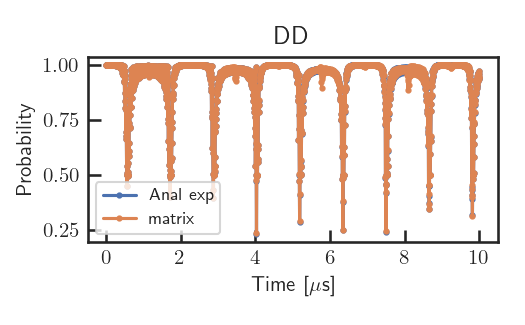

In [75]:
start = 10e-6 # in ms
duration = 10e-3 # in ms
incre = 5e-6
Taus = np.arange(start,start+duration, incre) # in ms
N_pi = 64 # number of pi pulses
N_meas = int(1e4)

Signal = []
Signal_anal = []
for tau in tqdm(Taus):
    sigma_z = unB_DD(fL, Azz, Azx, tau, tau, N_pi, s1=0.5, s0=-0.5)
    Signal.append(sigma_z)
    sigma_z = anal_DD_general(fL, Azz, Azx, tau, N_pi, s1=0.5, s0=-0.5)
    Signal_anal.append(sigma_z)
Signal = np.array(Signal)
Signal_anal = np.array(Signal_anal)
p = 0.5-0.5*Signal # probability to be in the initial state (bright state)
p_anal = 0.5-0.5*Signal_anal # probability to be in the initial state (bright state)
#p_noisy = Generate_noisy_signal(p, N_meas)

plt.figure(dpi=150, figsize=(3.5,3.5/1.61803398875))
plt.plot(Taus*1000, p_anal, '-o',markersize=2, alpha = 1, label='Anal exp')
plt.plot(Taus*1000, p, '-o',markersize=2, alpha = 1, label='matrix')
plt.xlabel("Time [$\mu$s]")
plt.ylabel('Probability')
plt.title('DD')
plt.legend()
plt.tight_layout()
#plt.savefig('HE_behavior.pdf')

In [42]:
a= np.array([1.21,0.99,0.98])
a.all()>1.0

False

In [50]:
np.round(-1.0002)

-1.0